In [4]:
from pathlib import Path
import sys
sys.path.insert(0, str(Path().absolute().parent))

import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics

from data.datasets import COLOR_DICT
from data.data_functions import DataLoader, PhaseTransform, NormalizePhaseTransform, SNIFFING_PATH
from data.sniffing_datasets import AlkanesShortSniff
from data.plot_functions import plot_array_data, plot_confusion_matrix
from data.utils import train_test_split, sort_by_set

SEED = 42

In [5]:
exp_set = AlkanesShortSniff()

train_set, test_set = train_test_split(exp_set, seed=SEED)

In [6]:

psi, labels = DataLoader(exp_set, transforms=[PhaseTransform, NormalizePhaseTransform], folder=SNIFFING_PATH).load()

Loading experimental data
(1/6) Pentane (8 exp.): [===================0] 100% complete
(2/6) Hexane (9 exp.): [===================0] 100% complete
(3/6) Heptane (9 exp.): [===================0] 100% complete
(4/6) Octane (10 exp.): [===================0] 100% complete
(5/6) Nonane (10 exp.): [===================0] 100% complete
(6/6) Decane (10 exp.): [===================0] 100% complete
Length of experimental set loaded: 56


#### Calculate SVM

In [7]:
def predict(SVC, test, lbl):
    predicted = SVC.predict(test)
    print("Validation accuracy: " + str(round(np.sum(predicted == lbl)/float(len(lbl)),3)) + " (" + str(np.sum(predicted == lbl)) + "/" + str(len(lbl)) + ")")

    # list scores
    print("Accuracy: " + str(round(metrics.accuracy_score(lbl, predicted),3)))
    print("Precision: " + str(round(metrics.recall_score(lbl, predicted, average="macro"),3)))
    print("F1 Score: " + str(round(metrics.f1_score(lbl, predicted, average="macro"),3)))

    return predicted

In [14]:
train_data, train_lbl, test_data, test_lbl = sort_by_set(psi, train_set, test_set)

In [23]:
for idx, x in enumerate(train_data):
    train_data[idx] = x[:240]

for idx, x in enumerate(test_data):
    test_data[idx] = x[:240]

In [24]:
SVC = svm.SVC(C=10,gamma=10, kernel="rbf")
SVC.fit(train_data, train_lbl)
print("Training accuracy: " + str(SVC.score(train_data, train_lbl)) + " (" + str(len(train_data)) + ")")

Training accuracy: 0.9142857142857143 (35)


In [25]:
predicted = predict(SVC, test_data, test_lbl)
print(f"\nMismatches (true, pred): {[(lbl, pred) for lbl,pred in (zip(test_lbl, predicted)) if lbl!=pred]}")

Validation accuracy: 0.952 (20/21)
Accuracy: 0.952
Precision: 0.944
F1 Score: 0.943

Mismatches (true, pred): [('Hexane', 'Heptane')]


#### Plot

Validation accuracy: 0.952 (20/21)
Accuracy: 0.952
Precision: 0.944
F1 Score: 0.943


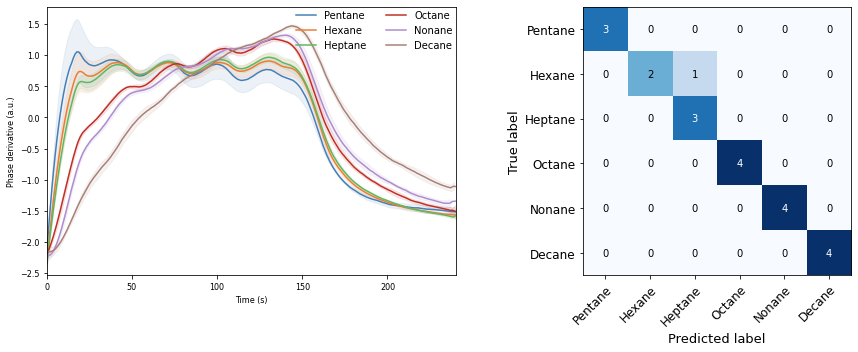

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

linestyle_dict = dict([
    ('Pentane', '-'),
    ('Hexane', '-'),
    ('Heptane', '-'),
    ('Octane', '-'),
    ('Nonane', '-'),
    ('Decane', '-'),
    ('Ethanol', ':'),
    ('Water', ':'),
    ('Acetone', ':'),
    ('Toluene', '-'),
    ('Acetonitrile', ':')
])

plot_array_data(exp_set, psi, [0,240], color_dict=COLOR_DICT, ax=axes[0])
axes[0].legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False)

#from IPython.utils import io
#with io.capture_output() as captured:
plot_confusion_matrix(test_lbl, predict(SVC, test_data, test_lbl), classes=list(exp_set.keys()), ax=axes[1])

plt.tight_layout()